In [1]:
#!pip install --upgrade cython setuptools wheel
#!brew install gcc
#conda install -c conda-forge gensim
#  Import Necessary Libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputert

from imblearn.over_sampling import SMOTE  #  Handling Imbalance

In [1]:
#  Load dataset
df = pd.read_csv('FrontDoorImages_Metadata.csv')

#  Handle missing values
df['Neuron_Suggestion_Keywords'] = df['Neuron_Suggestion_Keywords'].fillna('unknown')

# Clean and preprocess keywords
def clean_keywords(keywords):
    cleaned = [kw.strip().replace(" ", "").lower() for kw in keywords.split(",")]
    return ",".join(cleaned)

df['Neuron_Processed_Keywords'] = df['Neuron_Suggestion_Keywords'].apply(clean_keywords)

#  Convert text to numerical format using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=3000)
X = vectorizer.fit_transform(df['Neuron_Processed_Keywords'].dropna())

#  Convert data into Gensim format for coherence scoring
texts = [text.split(",") for text in df['Neuron_Processed_Keywords'].dropna()]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

#  Function to compute coherence score dynamically
def compute_coherence_score(n_topics):
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_model.fit(X)

    words = vectorizer.get_feature_names_out()
    topics = [[words[j] for j in topic.argsort()[-10:]] for topic in lda_model.components_]

    topic_word_ids = [[dictionary.token2id[word] for word in topic if word in dictionary.token2id] for topic in topics]

    if any(len(topic) == 0 for topic in topic_word_ids):
        return 0  # Prevent empty topics from affecting coherence

    coherence_model = CoherenceModel(topics=topic_word_ids, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

#  Compute coherence scores for a range of topics
topic_range = range(3, 12)  # Testing topics from 3 to 11
coherence_scores = [compute_coherence_score(n) for n in topic_range]

#  Get the top 3 best topic counts based on coherence scores
top_3_indices = np.argsort(coherence_scores)[-3:][::-1]  # Get indices of top 3 scores
top_3_topics = [topic_range[i] for i in top_3_indices]
print(f" Best 3 topic counts based on coherence score: {top_3_topics}")

#  Function to apply LDA and extract topics dynamically
def apply_lda(n_components, X, vectorizer):
    """Train LDA model and return topic assignments and extracted topics"""
    lda = LatentDirichletAllocation(n_components=n_components, random_state=42)
    lda.fit(X)

    words = vectorizer.get_feature_names_out()
    topics_dict = {}

    # Extract Top Words for Each Topic
    print(f"\n LDA with {n_components} topics:")
    for i, topic in enumerate(lda.components_):
        top_words = [words[j] for j in topic.argsort()[-10:]]  # Get top 10 words per topic
        topics_dict[f"Topic {i+1}"] = top_words
        print(f" Topic {i+1}: {', '.join(top_words)}")

    # Assign topics to each row in the dataset
    topic_assignments = lda.transform(X).argmax(axis=1)
    return topic_assignments, topics_dict

#  Apply LDA for the **top 3 best coherence scores**
topics_summary = {}
for n_topics in top_3_topics:
    df[f'Topic_{n_topics}'], topics_summary[f'Topics_{n_topics}'] = apply_lda(n_topics, X, vectorizer)

#  Save Final Dataset with Multiple Topic Assignments
df.to_csv('Post_Front_Door_Image_Info_With_Top_3_Topics.csv', index=False)
print(" Final dataset with multiple topic assignments saved!")

#  Save Topics Summary Separately
topics_df = pd.DataFrame.from_dict(topics_summary, orient='index').transpose()
topics_df.to_csv('Post_LDA_Topics_Top_3_Summary.csv', index=False)
print(" Topics summary for top 3 coherence scores saved separately!")

 Best 3 topic counts based on coherence score: [3, 5, 4]

 LDA with 3 topics:
 Topic 1: informationclarity, layoutclarity, adddecoration, decorativeelements, brandvisibility, displayoptimization, lowlightvisibility, signageappeal, promotionalappeal, enhancelighting
 Topic 2: seasonalengagement, enhancedvisibility, brandidentity, visualclarity, dynamicdesign, simplifiedpresentation, contrast, customerengagement, promotionalappeal, enhancevisibility
 Topic 3: modernization, customerguidance, enhanceentrance, visualappeal, readability, visualengagement, signagevisibility, nightvisibility, eveningvisibility, unknown

 LDA with 5 topics:
 Topic 1: engagement, visibilityenhancement, addseating, adddecoration, decorativeelements, displayoptimization, lowlightvisibility, signageappeal, promotionalappeal, enhancelighting
 Topic 2: clarity, accessibility, designclarity, enhancedvisibility, contrast, simplifiedpresentation, dynamicdesign, customerengagement, promotionalappeal, enhancevisibility
 

Mutual Information Scores for Topic_3:
 Neuron_Engagement          0.254066
Neuron_Focus               0.145356
Neuron_Clarity             0.042996
Neuron_Cognitive Demand    0.028774
dtype: float64

Mutual Information Scores for Topic_4:
 Neuron_Engagement          0.267758
Neuron_Focus               0.196720
Neuron_Clarity             0.133790
Neuron_Cognitive Demand    0.086595
dtype: float64

Mutual Information Scores for Topic_5:
 Neuron_Engagement          0.267758
Neuron_Focus               0.196720
Neuron_Clarity             0.133790
Neuron_Cognitive Demand    0.086595
dtype: float64


/var/folders/jh/9y_bmz351z11rkp4r34j4xsw0000gn/T/ipykernel_210/1916616109.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores_topic3.values, y=mi_scores_topic3.index, palette="viridis")
/var/folders/jh/9y_bmz351z11rkp4r34j4xsw0000gn/T/ipykernel_210/1916616109.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores_topic4.values, y=mi_scores_topic4.index, palette="viridis")
/var/folders/jh/9y_bmz351z11rkp4r34j4xsw0000gn/T/ipykernel_210/1916616109.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores_topic5.val

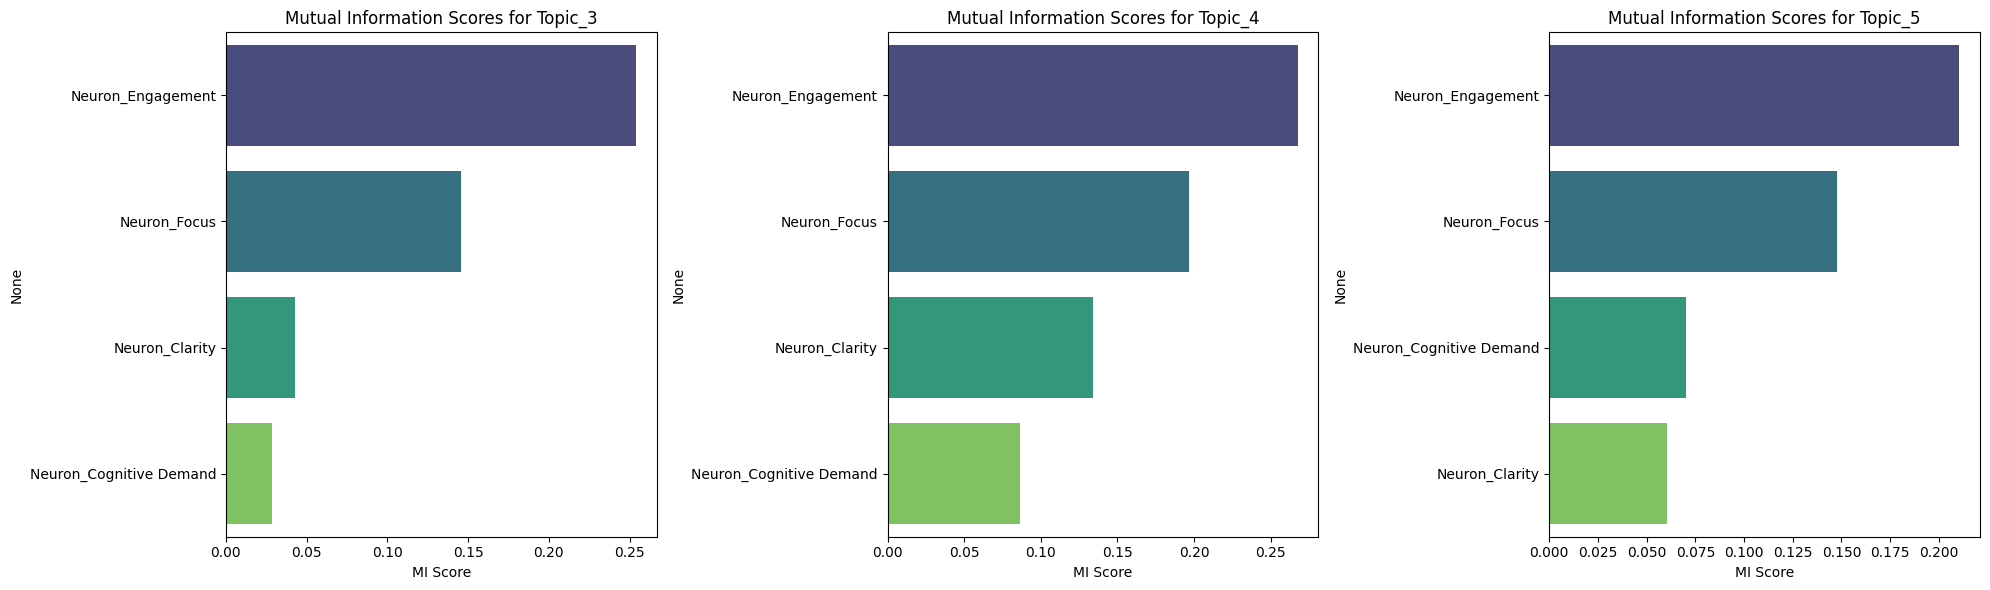

In [12]:
#Check the MI for 4 neuron_* variables

# Define features and targets
imputer = SimpleImputer(strategy='mean')
X = df[['Neuron_Focus', 'Neuron_Cognitive Demand', 'Neuron_Clarity', 'Neuron_Engagement']]
X_imputed = imputer.fit_transform(X)

# Compute MI for Topic_3
y_topic3 = df['Topic_3']
mi_scores_topic3 = mutual_info_classif(X_imputed, y_topic3, random_state=42)
mi_scores_topic3 = pd.Series(mi_scores_topic3, index=X.columns).sort_values(ascending=False)
print("Mutual Information Scores for Topic_3:\n", mi_scores_topic3)

# Compute MI for Topic_4
y_topic4 = df['Topic_4']
mi_scores_topic4 = mutual_info_classif(X_imputed, y_topic4, random_state=42)
mi_scores_topic4 = pd.Series(mi_scores_topic4, index=X.columns).sort_values(ascending=False)
print("\nMutual Information Scores for Topic_4:\n", mi_scores_topic4)

# Compute MI for Topic_5
y_topic5 = df['Topic_5']
mi_scores_topic5 = mutual_info_classif(X_imputed, y_topic5, random_state=42)
mi_scores_topic5 = pd.Series(mi_scores_topic5, index=X.columns).sort_values(ascending=False)
print("\nMutual Information Scores for Topic_5:\n", mi_scores_topic4)

# Visualize MI scores
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
sns.barplot(x=mi_scores_topic3.values, y=mi_scores_topic3.index, palette="viridis")
plt.title("Mutual Information Scores for Topic_3")
plt.xlabel("MI Score")

plt.subplot(1, 3, 2)
sns.barplot(x=mi_scores_topic4.values, y=mi_scores_topic4.index, palette="viridis")
plt.title("Mutual Information Scores for Topic_4")
plt.xlabel("MI Score")

plt.subplot(1, 3, 3)
sns.barplot(x=mi_scores_topic5.values, y=mi_scores_topic5.index, palette="viridis")
plt.title("Mutual Information Scores for Topic_5")
plt.xlabel("MI Score")

plt.tight_layout()
plt.show()


In [7]:
def train_evaluate_and_visualize(X, y, topic_name):
    print(f"\n Processing {topic_name}...\n{'-' * 50}")

    #  Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    #  Apply SMOTE for balancing classes
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    #  Models and Hyperparameters
    models = {
        "Logistic Regression": {
            "model": LogisticRegression(max_iter=2000, random_state=42),
            "params": {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear']}
        },
        "Random Forest": {
            "model": RandomForestClassifier(random_state=42),
            "params": {
                'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10]
            }
        },
        "XGBoost": {
            "model": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
            "params": {
                'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 10],
                'learning_rate': [0.01, 0.05, 0.1, 0.2]
            }
        }
    }

    #  Train and Tune Models
    best_models = {}
    for name, details in models.items():
        print(f"\n🔍 Finding best parameters for {name}...")
        grid_search = GridSearchCV(
            details["model"], details["params"],
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            n_jobs=-1, verbose=1
        )
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_

        print(f"Best parameters for {name}: {grid_search.best_params_}")

    #  Evaluate Models
    performance = {}
    for name, model in best_models.items():
        print(f"\n {name} Classification Report:")
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred))

        # Store accuracy and AUC scores
        performance[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'AUC': roc_auc_score(pd.get_dummies(y_test), model.predict_proba(X_test), multi_class='ovr', average='macro')
        }

    #  Save Performance Metrics
    performance_df = pd.DataFrame(performance).T
    print("\n Performance Metrics:")
    print(performance_df)

    #  Plot ROC Curves
    plt.figure(figsize=(10, 8))
    for name, model in best_models.items():
        y_pred_prob = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(pd.get_dummies(y_test).values.ravel(), y_pred_prob.ravel())
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curve for {topic_name}')
    plt.legend()
    plt.grid()
    plt.show()

    #  Confusion Matrices
    for name, model in best_models.items():
        y_pred_test = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred_test)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"{name} - Test Set Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    return performance_df


In [15]:
# Load Data
df = pd.read_csv('Post_Front_Door_Image_Info_With_Top_3_Topics.csv')
# Preprocessing Pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])


📊 Training Model for Topic_3

 Processing Topic_3...
--------------------------------------------------

🔍 Finding best parameters for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'C': 100, 'solver': 'liblinear'}

🔍 Finding best parameters for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

🔍 Finding best parameters for XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}

 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.55      0.40        11
           1       0.64      0.37      0.47        19
           2       0.50      0.50      0.50        14

    accuracy                           0.45        44
   macro avg       0.48      0.47      0.46        44
weighted avg       0.51      0.45      0.46        44


 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.45      0.40        11
           1       0.36      0.42      0.39        19
           2       0.38      0.21      0.27        14

    accuracy                           0.36        44
   macro avg       0.37      0.36      0.35        44
weighted avg       0.37      0.36      0.36        44


 XGBoost Classification Report:
              precision    reca

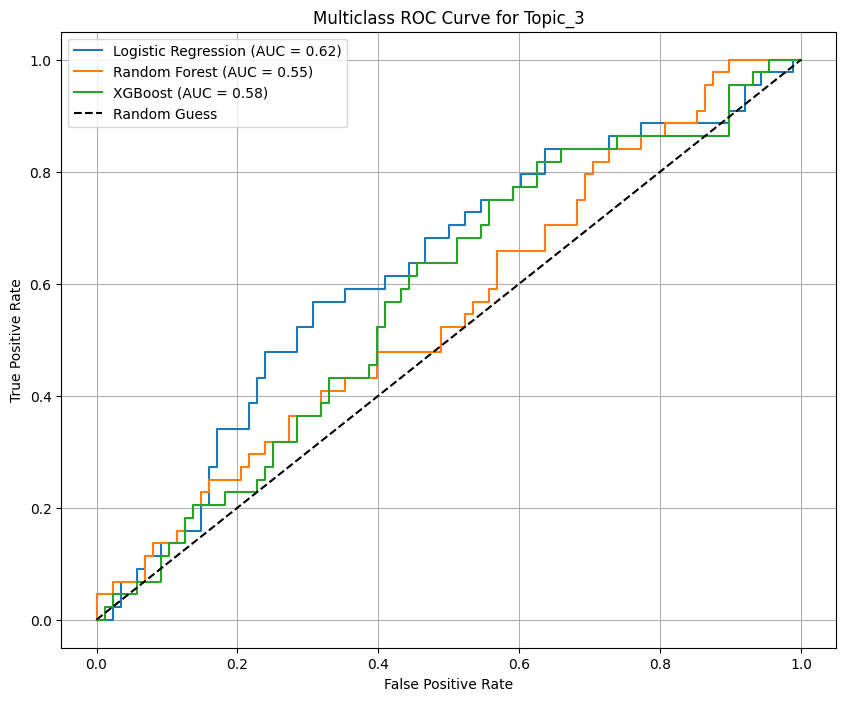

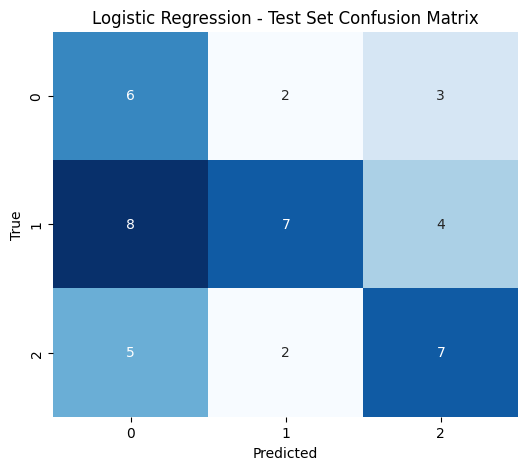

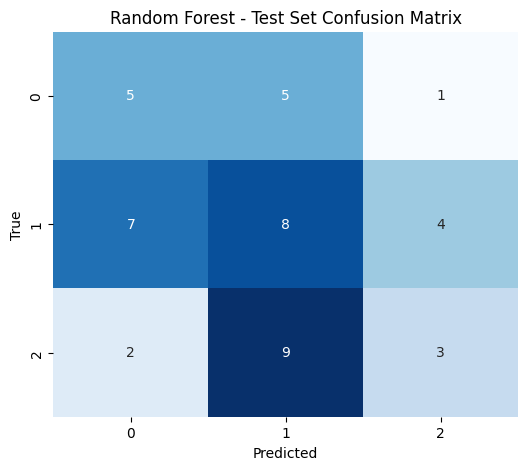

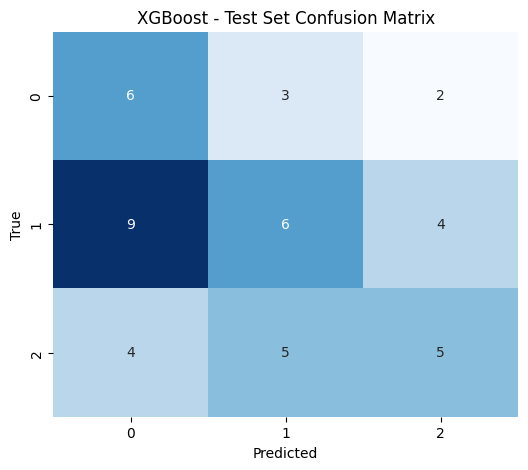


📊 Training Model for Topic_4

 Processing Topic_4...
--------------------------------------------------

🔍 Finding best parameters for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'C': 100, 'solver': 'lbfgs'}

🔍 Finding best parameters for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

🔍 Finding best parameters for XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}

 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.36      0.33        11
           1       0.38      0.33      0.35        18
           2       0.21      0.30      0.25        10
           3       0.00      0.00      0.00         5

    accuracy                           0.30        44
   macro avg       0.22      0.25      0.23        44
weighted avg       0.28      0.30      0.28        44


 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.36      0.36        11
           1       0.45      0.50      0.47        18
           2       0.45      0.50      0.48        10
           3       0.00      0.00      0.00         5

    accuracy                           0.41        44
   macro avg       0.32      0.34      0.33        44
weighted av

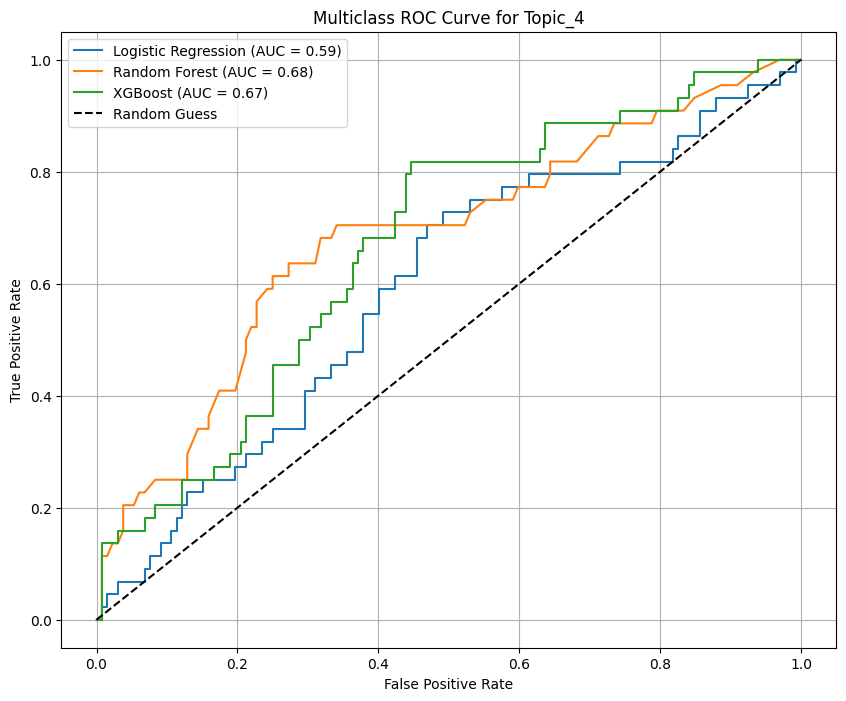

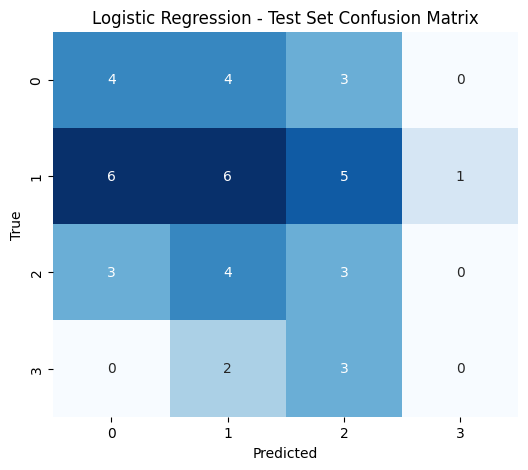

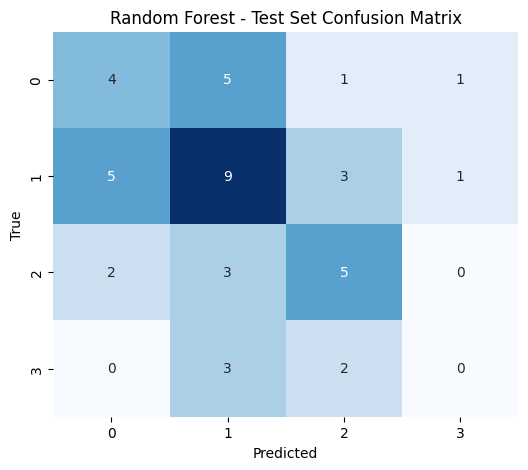

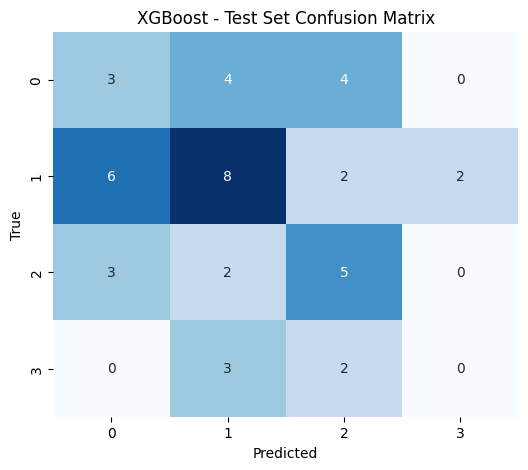


📊 Training Model for Topic_5

 Processing Topic_5...
--------------------------------------------------

🔍 Finding best parameters for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'C': 100, 'solver': 'liblinear'}

🔍 Finding best parameters for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

🔍 Finding best parameters for XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}

 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.20      0.27        10
           1       0.18      0.20      0.19        10
           2       0.22      0.18      0.20        11
           3       0.00      0.00      0.00         5
           4       0.27      0.38      0.32         8

    accuracy                           0.20        44
   macro avg       0.22      0.19      0.19        44
weighted avg       0.24      0.20      0.21        44


 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.20      0.22        10
           1       0.36      0.50      0.42        10
           2       0.36      0.36      0.36        11
           3       0.17      0.20      0.18         5
           4       0.60      0.38      0.46         8

    accurac

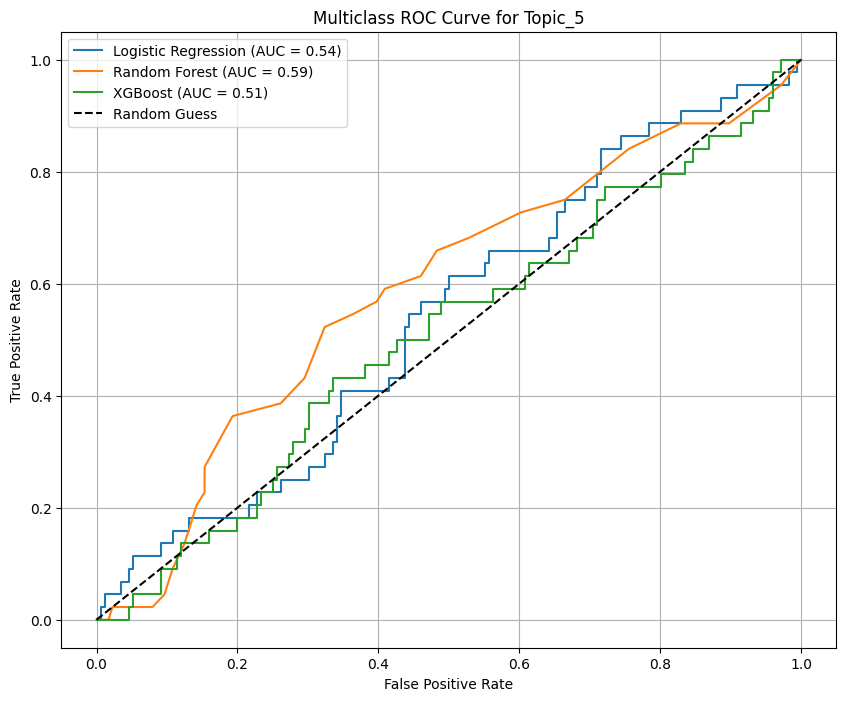

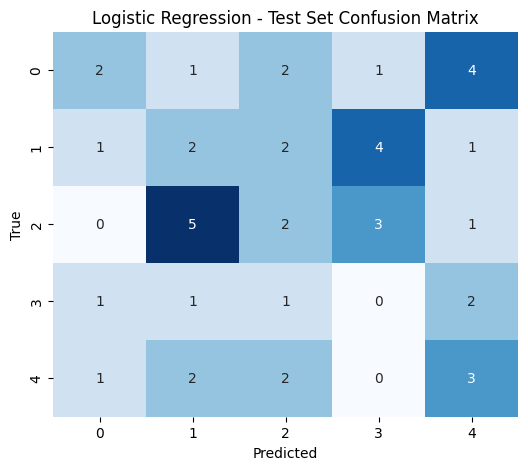

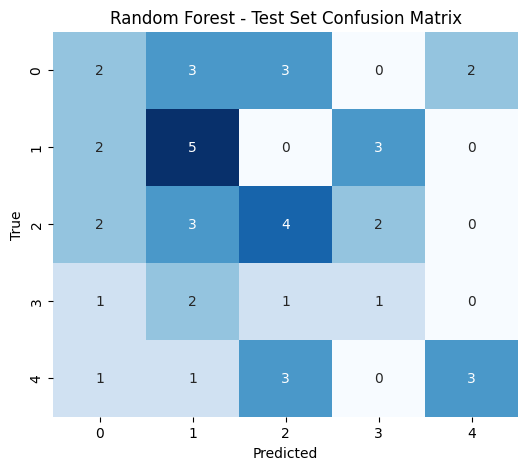

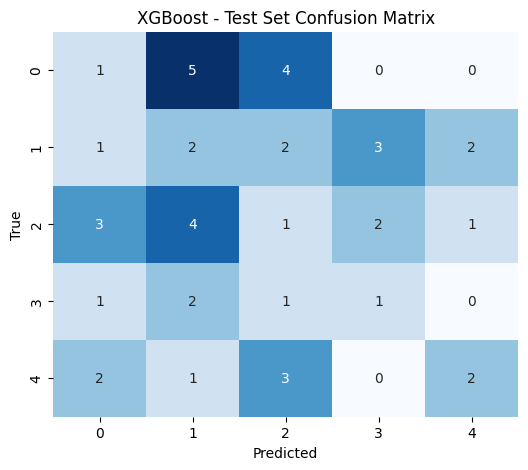


 All performance metrics saved to 'Without_4_Neuron_Model_Performance_Topics.csv'!


In [16]:
######################################################################
###### Train Models for Each Topic without all Neuron_* variables ####
######################################################################

# Select Relevant Columns
selected_columns1 = [
    'Folder_Name', 'Store_Category', 'Store_Location',
    'Rescaled_NIMA Score', 'Rescaled_Paq2piq Average Local Score',
    'Rescaled_Paq2piq Normalized Global Score', 'Rescaled_Paq2piq Class',
    'Topic_3', 'Topic_4', 'Topic_5'
]
df1 = df[selected_columns1]

# Separate Features (X) and Target (y)
numerical_cols = ['Rescaled_NIMA Score', 'Rescaled_Paq2piq Average Local Score', 'Rescaled_Paq2piq Normalized Global Score']
categorical_cols = ['Folder_Name', 'Store_Category', 'Store_Location', 'Rescaled_Paq2piq Class']
target_cols = ['Topic_3', 'Topic_4', 'Topic_5']



# Train Models for Each Topic (without All Neuron_* Variables)
final_performance = {}
for topic in target_cols:
    print(f"\n📊 Training Model for {topic}")
    X_processed = preprocessor.fit_transform(df1.drop(columns=target_cols))
    y = df1[topic]
    final_performance[topic] = train_evaluate_and_visualize(X_processed, y, topic)

#  Save Performance Results
final_performance_df = pd.concat(final_performance, axis=0)
final_performance_df.to_csv('Post_Without_4Neuron_Model_Performance.csv')
print("\n All performance metrics saved to 'Post_Without_4Neuron_Model_Performance.csv'!")


📊 Training Model for Topic_3

 Processing Topic_3...
--------------------------------------------------

🔍 Finding best parameters for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'C': 100, 'solver': 'liblinear'}

🔍 Finding best parameters for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

🔍 Finding best parameters for XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:42:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}

 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.55      0.40        11
           1       0.64      0.37      0.47        19
           2       0.50      0.50      0.50        14

    accuracy                           0.45        44
   macro avg       0.48      0.47      0.46        44
weighted avg       0.51      0.45      0.46        44


 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.45      0.40        11
           1       0.36      0.42      0.39        19
           2       0.38      0.21      0.27        14

    accuracy                           0.36        44
   macro avg       0.37      0.36      0.35        44
weighted avg       0.37      0.36      0.36        44


 XGBoost Classification Report:
              precision    reca

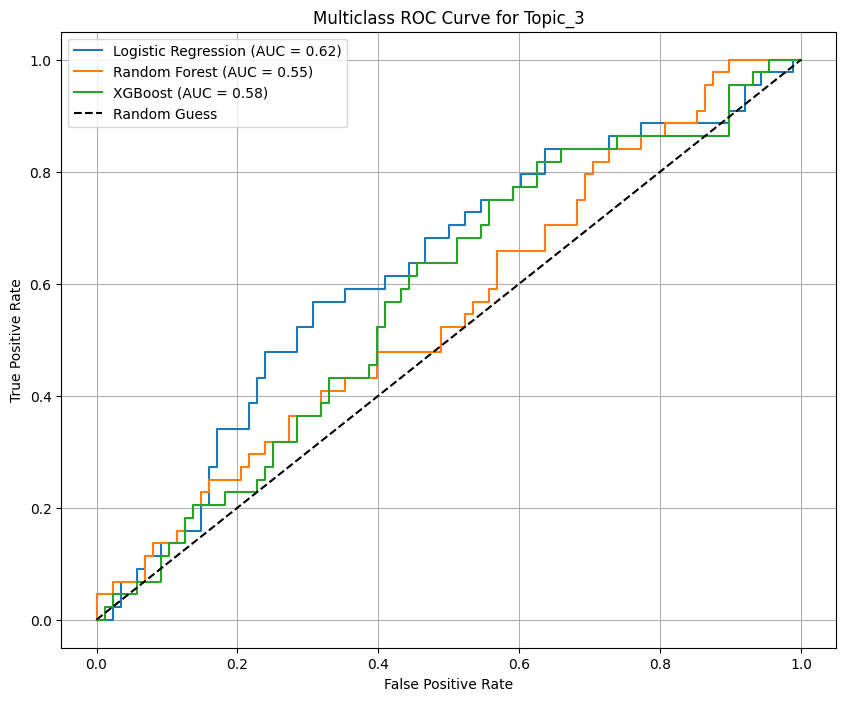

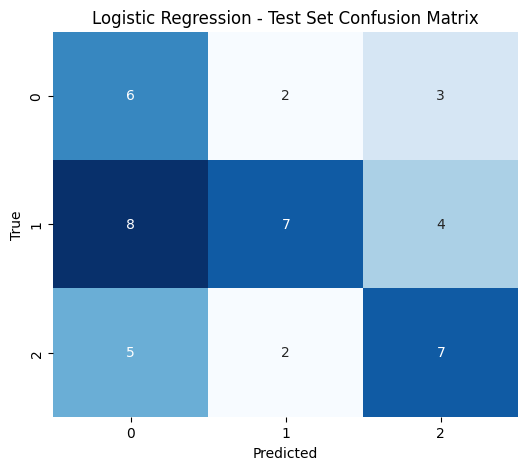

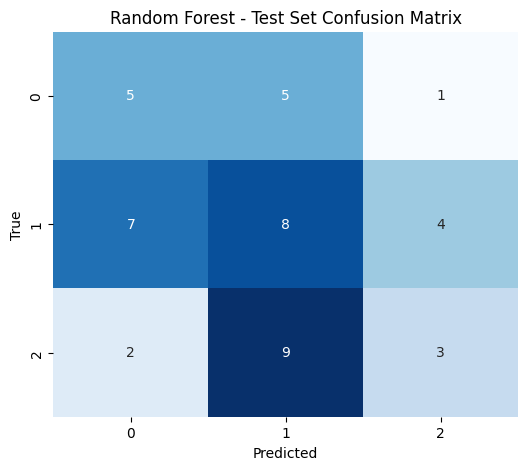

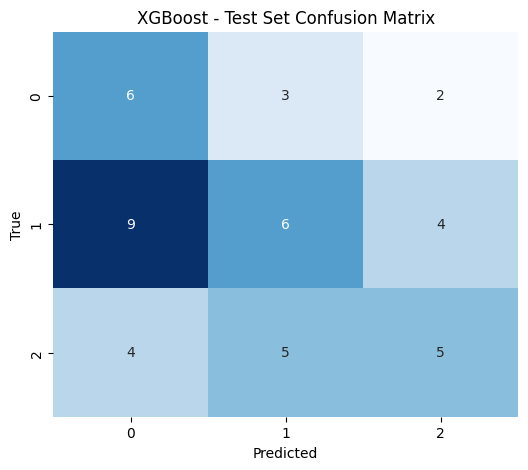


📊 Training Model for Topic_4

 Processing Topic_4...
--------------------------------------------------

🔍 Finding best parameters for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'C': 100, 'solver': 'lbfgs'}

🔍 Finding best parameters for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

🔍 Finding best parameters for XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}

 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.36      0.33        11
           1       0.38      0.33      0.35        18
           2       0.21      0.30      0.25        10
           3       0.00      0.00      0.00         5

    accuracy                           0.30        44
   macro avg       0.22      0.25      0.23        44
weighted avg       0.28      0.30      0.28        44


 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.36      0.36        11
           1       0.45      0.50      0.47        18
           2       0.45      0.50      0.48        10
           3       0.00      0.00      0.00         5

    accuracy                           0.41        44
   macro avg       0.32      0.34      0.33        44
weighted av

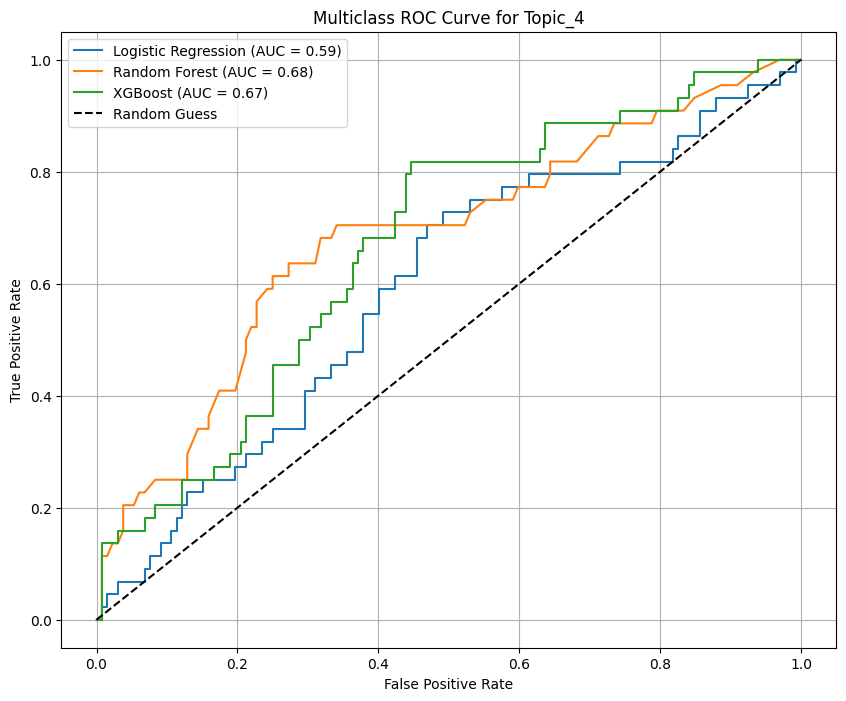

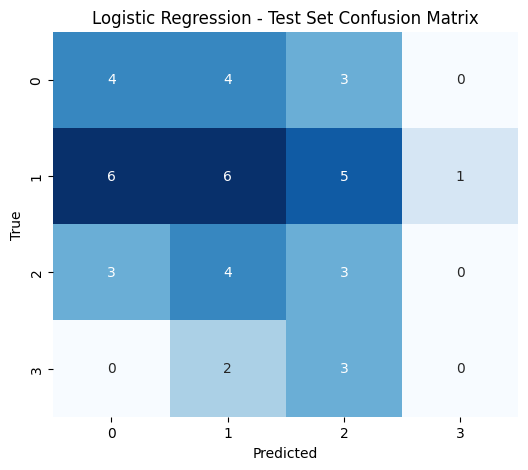

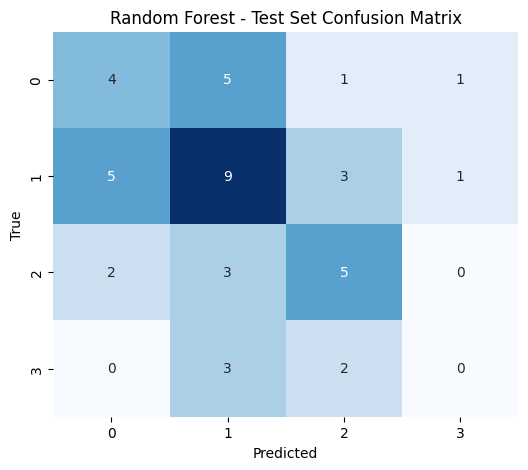

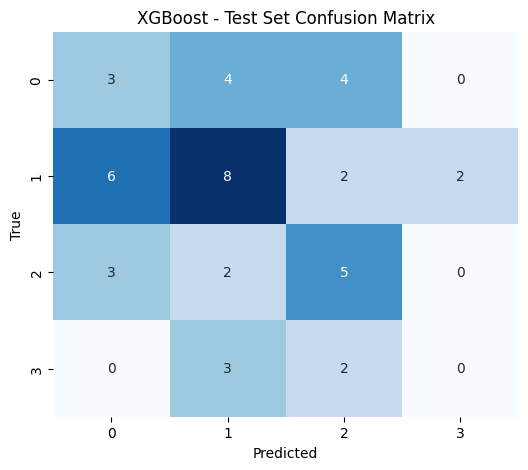


📊 Training Model for Topic_5

 Processing Topic_5...
--------------------------------------------------

🔍 Finding best parameters for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'C': 100, 'solver': 'liblinear'}

🔍 Finding best parameters for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

🔍 Finding best parameters for XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}

 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.20      0.27        10
           1       0.18      0.20      0.19        10
           2       0.22      0.18      0.20        11
           3       0.00      0.00      0.00         5
           4       0.27      0.38      0.32         8

    accuracy                           0.20        44
   macro avg       0.22      0.19      0.19        44
weighted avg       0.24      0.20      0.21        44


 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.20      0.22        10
           1       0.36      0.50      0.42        10
           2       0.36      0.36      0.36        11
           3       0.17      0.20      0.18         5
           4       0.60      0.38      0.46         8

    accurac

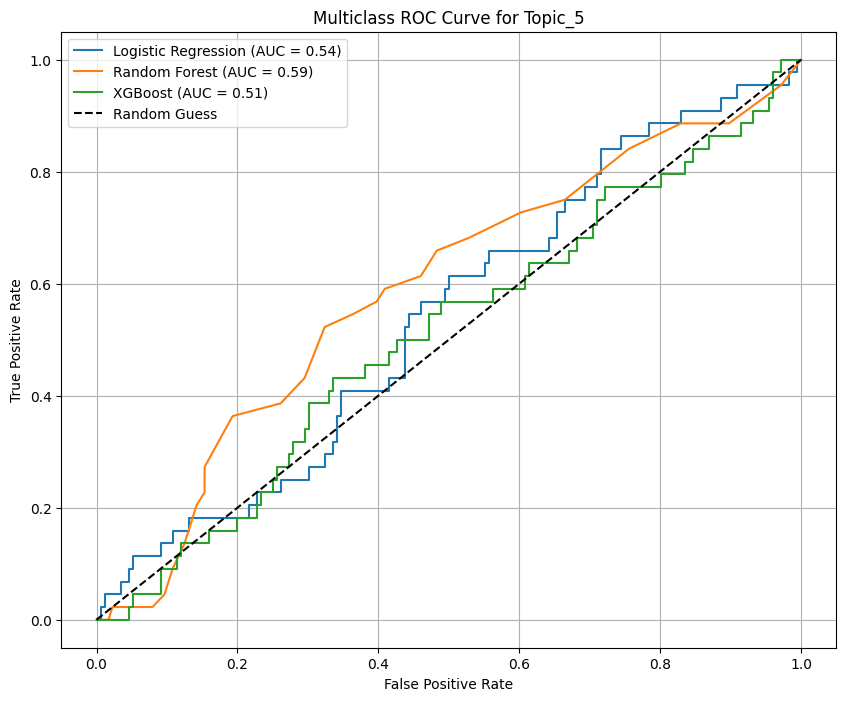

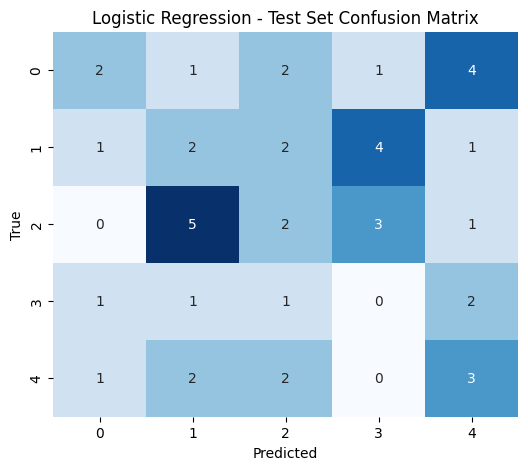

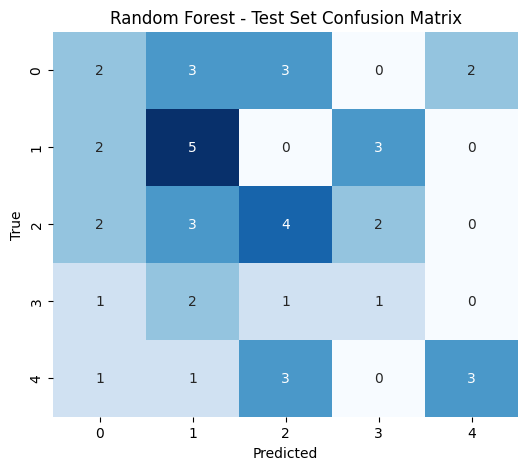

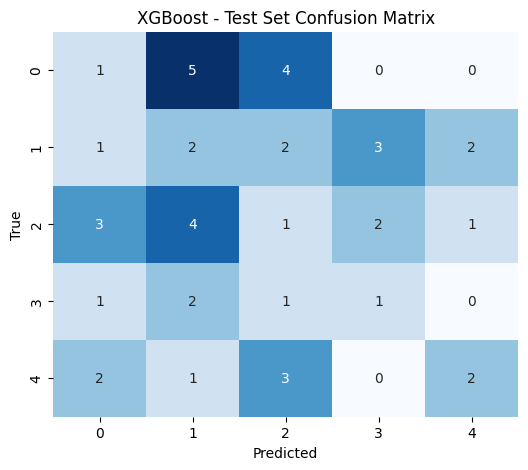


 All performance metrics saved to 'Without_Clarity&Demand_Neuron_Model_Performance_Topics.csv'!


In [17]:
#######################################################################################
###### Train Models for Each Topic with Neuron_Clarity and Neuron_Cognitive Demand ####
#######################################################################################

#  Select Relevant Columns
selected_columns2 = [
    'Folder_Name', 'Store_Category', 'Store_Location',
    'Rescaled_NIMA Score', 'Rescaled_Paq2piq Average Local Score',
    'Rescaled_Paq2piq Normalized Global Score', 'Rescaled_Paq2piq Class',
    'Neuron_Focus','Neuron_Engagement',
    'Topic_3', 'Topic_4', 'Topic_5'
]
df2 = df[selected_columns2]

#Separate Features (X) and Target (y) ######### Without Neuron_Clarity and Neuron_Cognitive Demand  ######
numerical_cols = ['Rescaled_NIMA Score', 'Rescaled_Paq2piq Average Local Score', 'Rescaled_Paq2piq Normalized Global Score', 'Neuron_Focus','Neuron_Engagement']
categorical_cols = ['Folder_Name', 'Store_Category', 'Store_Location', 'Rescaled_Paq2piq Class']
target_cols = ['Topic_3', 'Topic_4', 'Topic_5']

#  Step 9: Train Models for Each Topic (without Neuron_Clarity and Neuron_Cognitive Demand)
final_performance = {}
for topic in target_cols:
    print(f"\n📊 Training Model for {topic}")
    X_processed = preprocessor.fit_transform(df2.drop(columns=target_cols))
    y = df2[topic]
    final_performance[topic] = train_evaluate_and_visualize(X_processed, y, topic)

#  Save Performance Results
final_performance_df = pd.concat(final_performance, axis=0)
final_performance_df.to_csv('Post_Without_Clarity&Demand_Neuron_Model_Performance.csv')
print("\n All performance metrics saved to 'Post_Without_Clarity&Demand_Neuron_Model_Performance.csv'!")


📊 Training Model for Topic_3

 Processing Topic_3...
--------------------------------------------------

🔍 Finding best parameters for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'C': 100, 'solver': 'liblinear'}

🔍 Finding best parameters for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

🔍 Finding best parameters for XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}

 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.55      0.40        11
           1       0.64      0.37      0.47        19
           2       0.50      0.50      0.50        14

    accuracy                           0.45        44
   macro avg       0.48      0.47      0.46        44
weighted avg       0.51      0.45      0.46        44


 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.45      0.40        11
           1       0.36      0.42      0.39        19
           2       0.38      0.21      0.27        14

    accuracy                           0.36        44
   macro avg       0.37      0.36      0.35        44
weighted avg       0.37      0.36      0.36        44


 XGBoost Classification Report:
              precision    reca

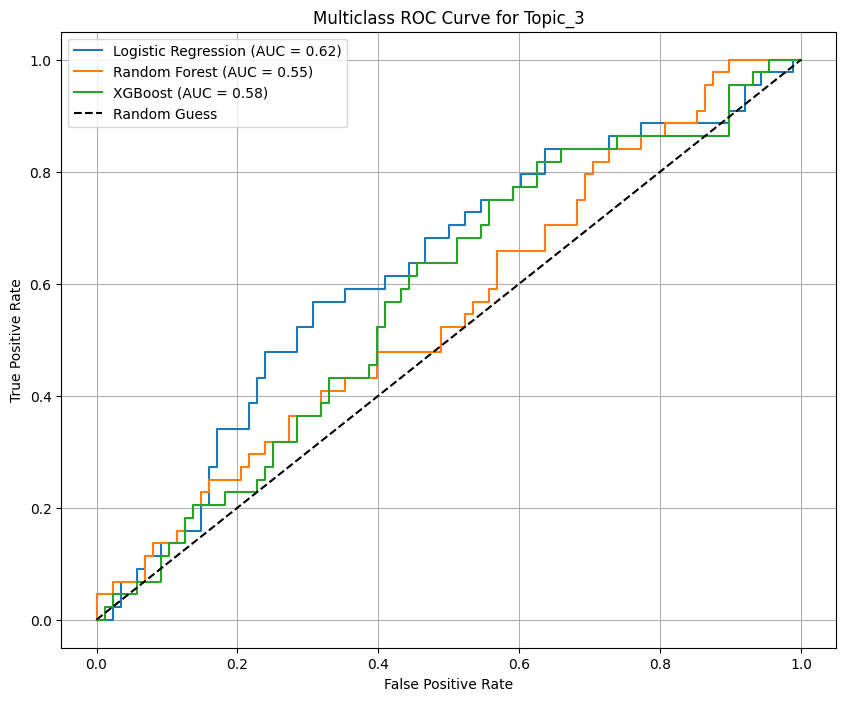

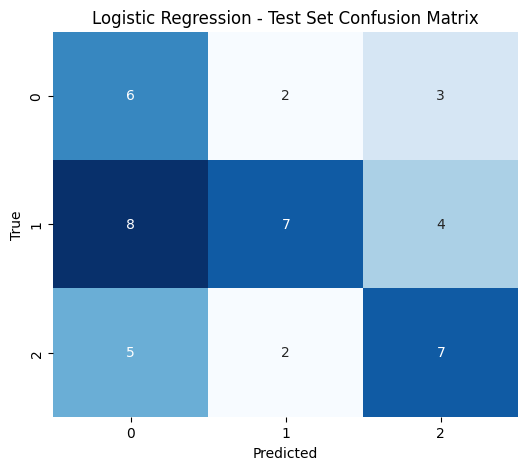

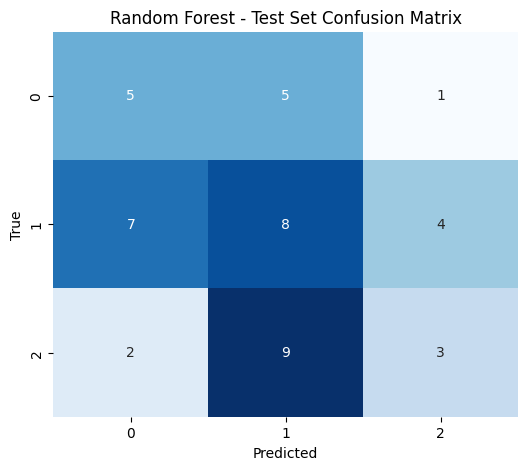

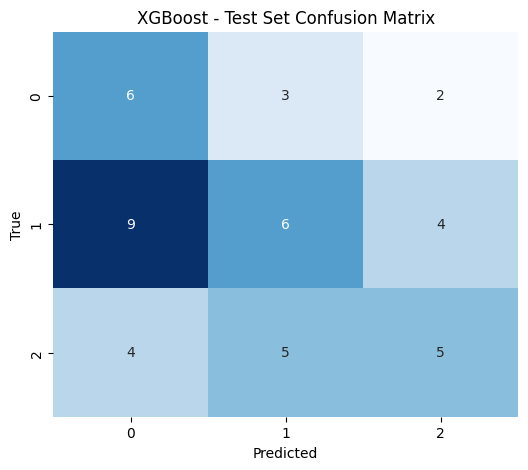


📊 Training Model for Topic_4

 Processing Topic_4...
--------------------------------------------------

🔍 Finding best parameters for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'C': 100, 'solver': 'lbfgs'}

🔍 Finding best parameters for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

🔍 Finding best parameters for XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:43:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}

 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.36      0.33        11
           1       0.38      0.33      0.35        18
           2       0.21      0.30      0.25        10
           3       0.00      0.00      0.00         5

    accuracy                           0.30        44
   macro avg       0.22      0.25      0.23        44
weighted avg       0.28      0.30      0.28        44


 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.36      0.36        11
           1       0.45      0.50      0.47        18
           2       0.45      0.50      0.48        10
           3       0.00      0.00      0.00         5

    accuracy                           0.41        44
   macro avg       0.32      0.34      0.33        44
weighted av

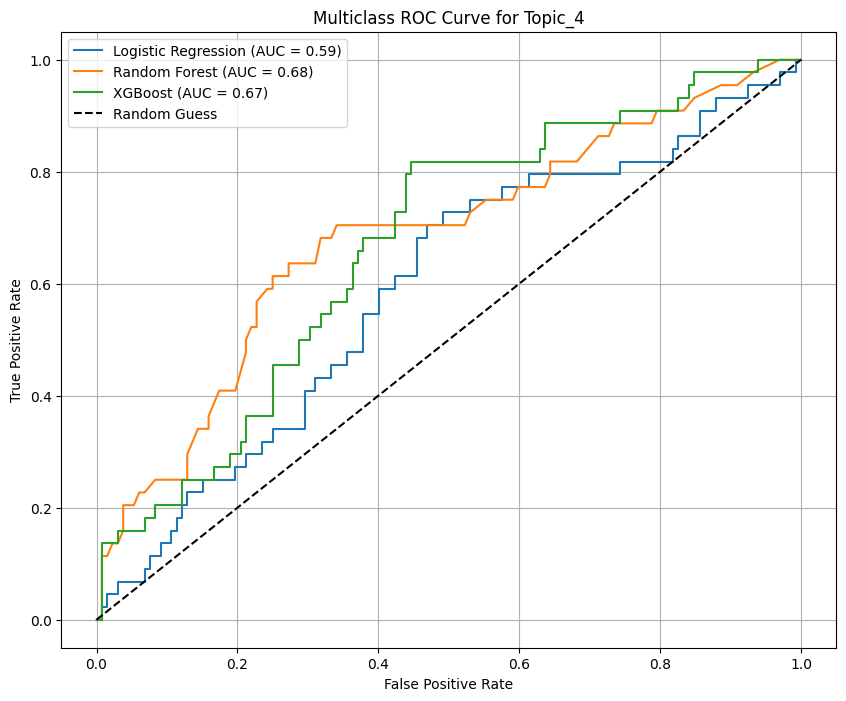

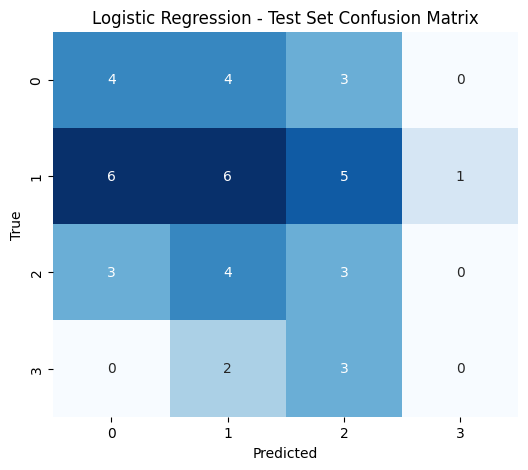

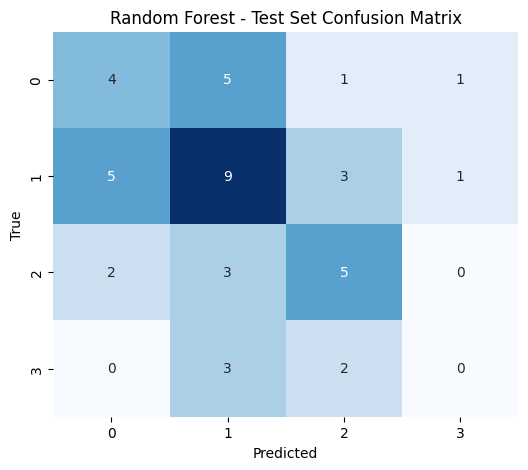

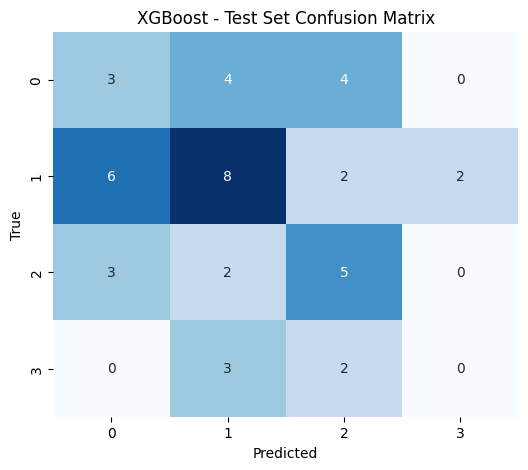


📊 Training Model for Topic_5

 Processing Topic_5...
--------------------------------------------------

🔍 Finding best parameters for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'C': 100, 'solver': 'liblinear'}

🔍 Finding best parameters for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

🔍 Finding best parameters for XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}

 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.20      0.27        10
           1       0.18      0.20      0.19        10
           2       0.22      0.18      0.20        11
           3       0.00      0.00      0.00         5
           4       0.27      0.38      0.32         8

    accuracy                           0.20        44
   macro avg       0.22      0.19      0.19        44
weighted avg       0.24      0.20      0.21        44


 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.20      0.22        10
           1       0.36      0.50      0.42        10
           2       0.36      0.36      0.36        11
           3       0.17      0.20      0.18         5
           4       0.60      0.38      0.46         8

    accurac

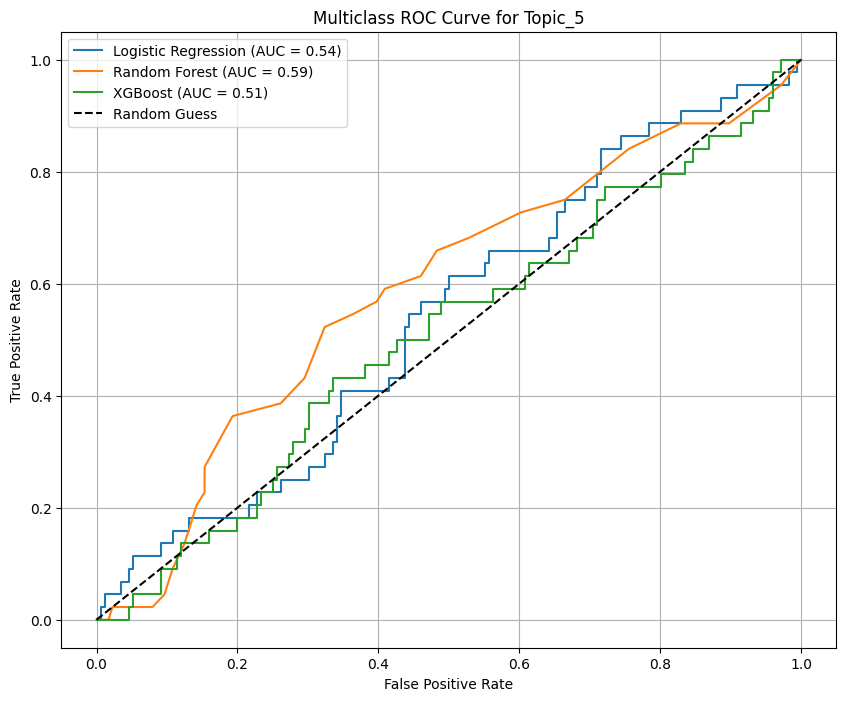

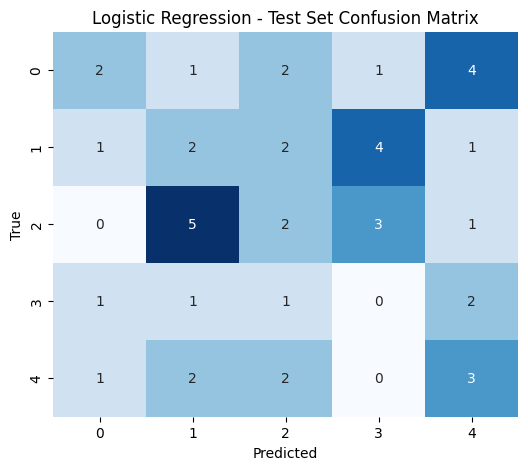

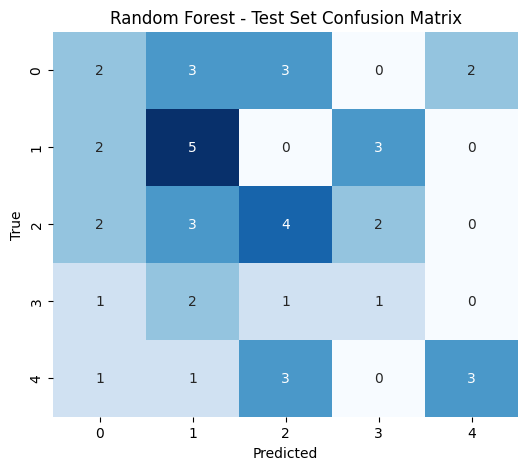

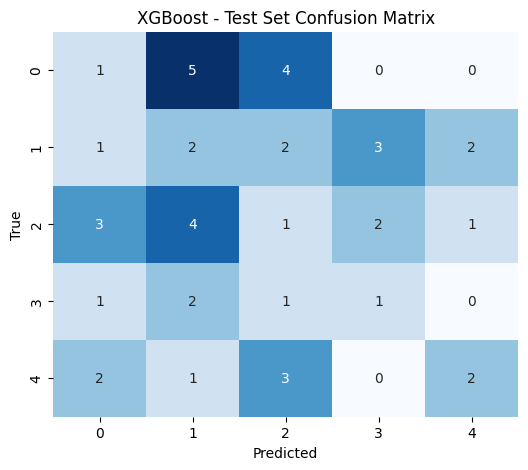


 All performance metrics saved to 'Neuron_Model_Performance_Topics.csv'!


In [18]:
#####################################################################
###### Train Models for Each Topic with all Neuron_* variables ######
#####################################################################

#  Step 2: Select Relevant Columns
selected_columns3 = [
    'Folder_Name', 'Store_Category', 'Store_Location',
    'Rescaled_NIMA Score', 'Rescaled_Paq2piq Average Local Score',
    'Rescaled_Paq2piq Normalized Global Score', 'Rescaled_Paq2piq Class',
    'Neuron_Focus','Neuron_Cognitive Demand','Neuron_Clarity','Neuron_Engagement',
    'Topic_3', 'Topic_4', 'Topic_5'
]
df3 = df[selected_columns3]

#  Step 3: Separate Features (X) and Target (y)
numerical_cols = ['Rescaled_NIMA Score', 'Rescaled_Paq2piq Average Local Score', 'Rescaled_Paq2piq Normalized Global Score', 'Neuron_Focus','Neuron_Cognitive Demand','Neuron_Clarity','Neuron_Engagement']
categorical_cols = ['Folder_Name', 'Store_Category', 'Store_Location', 'Rescaled_Paq2piq Class']
target_cols = ['Topic_3', 'Topic_4', 'Topic_5']

#  Step 5: Train Models for Each Topic  (with All Neuron_* Variables) 
final_performance = {}
for topic in target_cols:
    print(f"\n📊 Training Model for {topic}")
    X_processed = preprocessor.fit_transform(df3.drop(columns=target_cols))
    y = df3[topic]
    final_performance[topic] = improved_train_evaluate_and_importance_analyze(X_processed, y, topic)

#  Save Performance Results
final_performance_df = pd.concat(final_performance, axis=0)
final_performance_df.to_csv('Post_Without_4Neuron_Model_Performance.csv')
print("\n All performance metrics saved to 'Post_Without_4Neuron_Model_Performance_Topics.csv'!")

